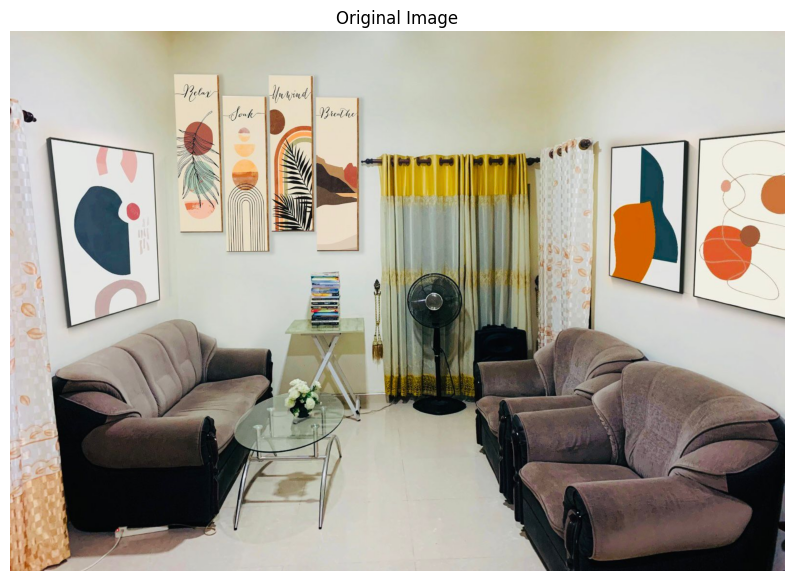

Enter the actual width of the room in meters: 10
Enter the actual height of the room in meters: 2
Instructions: Click to mark the vertices of a polygon around each object. Right-click to close the polygon. Press 'Enter' to finish marking an object, and 'Esc' to finish all.
Area-Based Complexity Score: 0.38
Entropy-Based Complexity Score: 0.43
Clutter Score: 1.16
Final Complexity Score: 0.47, Complexity Level: Low


In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.stats import entropy
import skfuzzy as fuzz
import skfuzzy.control as ctrl

# Function to display an image
def display_image(title, image):
    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

# Function to resize the image to fit within the screen
def resize_image(image, max_width=800, max_height=600):
    height, width = image.shape[:2]
    aspect_ratio = width / height

    if width > max_width:
        width = max_width
        height = int(width / aspect_ratio)
    
    if height > max_height:
        height = max_height
        width = int(height * aspect_ratio)
    
    resized_image = cv2.resize(image, (width, height))
    return resized_image

# Function to get user input for marking objects
def user_mark_objects(image):
    marked_image = image.copy()
    rois = []  # List to hold regions of interest

    print("Instructions: Click to mark the vertices of a polygon around each object. Right-click to close the polygon. Press 'Enter' to finish marking an object, and 'Esc' to finish all.")
    
    def line_drawer(event, x, y, flags, param):
        nonlocal rois, marked_image
        if event == cv2.EVENT_LBUTTONDOWN:  # Left click, select point
            cv2.circle(marked_image, (x, y), 5, (0, 255, 0), -1)
            points.append((x, y))
        elif event == cv2.EVENT_RBUTTONDOWN:  # Right click, close polygon
            if len(points) > 0:
                cv2.polylines(marked_image, [np.array(points)], True, (255, 0, 0), 2)
                rois.append(points.copy())
                points.clear()
        if points:
            cv2.polylines(marked_image, [np.array(points)], False, (0, 255, 0), 1)
        cv2.imshow('Mark Objects', marked_image)

    points = []
    cv2.imshow('Mark Objects', marked_image)
    cv2.setMouseCallback('Mark Objects', line_drawer)

    while True:
        key = cv2.waitKey(1) & 0xFF
        if key == 27:  # ESC to exit
            break

    cv2.destroyAllWindows()
    return rois

# Calculate the area-based complexity score
def calculate_area_based_complexity_score(rois, room_width, room_height, image):
    # Convert room dimensions from meters to pixels
    pixels_per_meter_x = image.shape[1] / room_width
    pixels_per_meter_y = image.shape[0] / room_height

    # Calculate total room area in pixel units
    total_room_area = pixels_per_meter_x * room_width * pixels_per_meter_y * room_height

    # Calculate total object area using polygons
    total_object_area = sum([cv2.contourArea(np.array(roi)) for roi in rois])
    
    total_overlap_area = 0.0
    
    image_shape = image.shape[:2]  # Use image shape here

    for i in range(len(rois)):
        for j in range(i + 1, len(rois)):
            poly1 = cv2.fillPoly(np.zeros(image_shape, dtype=np.uint8), [np.array(rois[i])], 1)
            poly2 = cv2.fillPoly(np.zeros(image_shape, dtype=np.uint8), [np.array(rois[j])], 1)
            overlap_area = np.sum((poly1 & poly2) > 0)
            total_overlap_area += overlap_area
    
    total_object_area_refine = total_object_area - total_overlap_area
    # Calculate space area
    space_area = total_room_area - total_object_area_refine

    # Calculate complexity score
    complexity_score = total_object_area_refine / (total_object_area_refine + space_area) if total_object_area_refine + space_area > 0 else 0
    return complexity_score

# Load an image and convert to grayscale
def load_image(image_path):
    image = Image.open(image_path)
    image = image.convert('L')  # Convert to grayscale
    return np.array(image)

# Calculate the entropy of an image
def calculate_entropy(image_array):
    histogram, _ = np.histogram(image_array, bins=256, range=(0, 255), density=True)
    return entropy(histogram)

# Normalize the entropy value
def normalize_entropy(entropy_value):
    max_entropy = np.log2(256)  # Maximum entropy for 8-bit image
    return entropy_value / max_entropy

# Calculate the entropy-based complexity score for marked objects
def calculate_entropy_based_complexity_score(image, rois):
    total_entropy = 0.0
    for roi in rois:
        mask = np.zeros(image.shape, dtype=np.uint8)
        cv2.fillPoly(mask, [np.array(roi)], 1)
        masked_image = image * mask
        entropy_value = calculate_entropy(masked_image)
        normalized_entropy = normalize_entropy(entropy_value)
        total_entropy += normalized_entropy * cv2.contourArea(np.array(roi))

    total_object_area = sum([cv2.contourArea(np.array(roi)) for roi in rois])
    entropy_based_complexity_score = total_entropy / total_object_area if total_object_area > 0 else 0
    return entropy_based_complexity_score

# Calculate the visual clutter score
def calculate_visual_clutter_score(rois, image_shape):
    total_overlap_area = 0.0
    total_density = 0.0
    total_object_area = sum([cv2.contourArea(np.array(roi)) for roi in rois])

    for i in range(len(rois)):
        for j in range(i + 1, len(rois)):
            poly1 = cv2.fillPoly(np.zeros(image_shape, dtype=np.uint8), [np.array(rois[i])], 1)
            poly2 = cv2.fillPoly(np.zeros(image_shape, dtype=np.uint8), [np.array(rois[j])], 1)
            overlap_area = np.sum((poly1 & poly2) > 0)
            total_overlap_area += overlap_area
    
    density = total_object_area / (image_shape[0] * image_shape[1])
    clutter_score = (total_overlap_area / total_object_area) * density if total_object_area > 0 else 0
    
    return clutter_score

def main():
    # Load the image
    image_path = "C:\\Users\\Asus\\Downloads\\images_for_complexity\\H5.jpg"
    image = cv2.imread(image_path)
    if image is None:
        print("Image not found. Check the file path.")
        return

    display_image("Original Image", image)

    # Resize image for marking objects
    resized_image = resize_image(image)

    # Get actual room dimensions from the user
    room_width = float(input("Enter the actual width of the room in meters: "))
    room_height = float(input("Enter the actual height of the room in meters: "))

    # User marks objects
    rois = user_mark_objects(resized_image)

    # Calculate area-based complexity score
    area_based_complexity_score = calculate_area_based_complexity_score(rois, room_width, room_height, resized_image)

    # Convert image to grayscale for entropy calculation
    gray_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)

    # Calculate entropy-based complexity score
    entropy_based_complexity_score = calculate_entropy_based_complexity_score(gray_image, rois)

    # Calculate visual clutter score
    visual_clutter_score = calculate_visual_clutter_score(rois, gray_image.shape)

    # Show individual results
    print(f"Area-Based Complexity Score: {area_based_complexity_score:.2f}")
    print(f"Entropy-Based Complexity Score: {entropy_based_complexity_score:.2f}")
    print(f"Clutter Score: {visual_clutter_score:.2f}")

    # Define the ranges for the inputs
    area_range = np.arange(0, 1.1, 0.1)
    entropy_range = np.arange(0, 1.1, 0.1)
    clutter_range = np.arange(0, 1.1, 0.1)
    complexity_range = np.arange(0, 1.1, 0.1)

    # Define the membership functions for area-based complexity
    area_low = fuzz.trimf(area_range, [0, 0, 0.35])
    area_high = fuzz.trimf(area_range, [0.35, 1, 1])

    # Define the membership functions for entropy-based complexity
    entropy_low = fuzz.trimf(entropy_range, [0, 0, 0.13])
    entropy_high = fuzz.trimf(entropy_range, [0.13, 1, 1])

    # Define the membership functions for visual clutter
    clutter_low = fuzz.trimf(clutter_range, [0, 0, 0.12])
    clutter_high = fuzz.trimf(clutter_range, [0.12, 1, 1])

    # Define the membership functions for overall complexity (only 'low' and 'high')
    complexity_low = fuzz.trimf(complexity_range, [0, 0, 0.5])
    complexity_high = fuzz.trimf(complexity_range, [0.5, 1, 1])

    # Define the fuzzy variables
    area = ctrl.Antecedent(area_range, 'area')
    entropy = ctrl.Antecedent(entropy_range, 'entropy')
    clutter = ctrl.Antecedent(clutter_range, 'clutter')
    complexity = ctrl.Consequent(complexity_range, 'complexity')

    # Assign the membership functions to the fuzzy variables
    area['low'] = area_low
    area['high'] = area_high

    entropy['low'] = entropy_low
    entropy['high'] = entropy_high

    clutter['low'] = clutter_low
    clutter['high'] = clutter_high

    complexity['low'] = complexity_low
    complexity['high'] = complexity_high

    # Define the fuzzy rules with priority to area-based complexity
    rule1 = ctrl.Rule(area['low'] & entropy['low'] & clutter['low'], complexity['low'])
    rule2 = ctrl.Rule(area['low'] & entropy['low'] & clutter['high'], complexity['low'])
    rule3 = ctrl.Rule(area['low'] & entropy['high'] & clutter['low'], complexity['low'])
    rule4 = ctrl.Rule(area['low'] & entropy['high'] & clutter['high'], complexity['low'])
    rule5 = ctrl.Rule(area['high'] & entropy['low'] & clutter['low'], complexity['high'])
    rule6 = ctrl.Rule(area['high'] & entropy['low'] & clutter['high'], complexity['high'])
    rule7 = ctrl.Rule(area['high'] & entropy['high'] & clutter['low'], complexity['high'])
    rule8 = ctrl.Rule(area['high'] & entropy['high'] & clutter['high'], complexity['high'])

    # Create the control system
    complexity_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8])
    complexity_sim = ctrl.ControlSystemSimulation(complexity_ctrl)

    # Function to compute the complexity score and determine the complexity level
    def calculate_complexity_and_determine_level(area_based_complexity_score, entropy_based_complexity_score, visual_clutter_score):
        
        complexity_sim.input['area'] = area_based_complexity_score
        complexity_sim.input['entropy'] = entropy_based_complexity_score
        complexity_sim.input['clutter'] = visual_clutter_score
        
        # Compute the fuzzy complexity
        complexity_sim.compute()

        # Get the output fuzzy result before defuzzification
        output_complexity = complexity_sim.output['complexity']
    
        # Evaluate membership values manually
        complexity_low_val = fuzz.interp_membership(complexity_range, complexity['low'].mf, output_complexity)
        complexity_high_val = fuzz.interp_membership(complexity_range, complexity['high'].mf, output_complexity)

        # Determine complexity level based on membership degrees
        if complexity_high_val > complexity_low_val:
            complexity_level = 'High'
        else:
            complexity_level = 'Low'

        return output_complexity, complexity_level

    final_complexity_score, complexity_level = calculate_complexity_and_determine_level(area_based_complexity_score, entropy_based_complexity_score, visual_clutter_score)
    print(f"Final Complexity Score: {final_complexity_score:.2f}, Complexity Level: {complexity_level}")

if __name__ == "__main__":
    main()
